In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

## Load Data

* take item 7798 as an example since it's continuous
* aggregate sales per day

In [2]:
#load data
df_train = pd.read_csv('./Data/orders0206_train.csv', sep = '|', parse_dates=['time'])
df_train_small = df_train[df_train["itemID"].isin([7798])]
display(df_train_small.head(3))

,time,transactID,itemID,order,salesPrice
226,2018-01-01 10:36:22,2256999,7798,2,10.97
731,2018-01-01 12:52:49,2263392,7798,1,10.97
2319,2018-01-01 16:39:16,2272248,7798,1,10.97


In [3]:
# aggregate sales per day
df_train_small['date'] = [d.date() for d in df_train_small['time']]
df_aggregated = df_train_small.groupby(['itemID','date']).size().to_frame().reset_index()
df_aggregated = df_aggregated.rename(columns={0: "count"})
df_aggregated.head()

,itemID,date,count
0,7798,2018-01-01,10
1,7798,2018-01-02,17
2,7798,2018-01-03,11
3,7798,2018-01-04,15
4,7798,2018-01-05,9


## Make Time Series & Train Test Split

* make series continous
* make date column as index
* take last 1 week period for testing

In [4]:
# add 0 sales for missing dates per itemID
for prod in df_aggregated.itemID.unique():
    s = df_aggregated.loc[df_aggregated['itemID'] == prod][["date","count"]]
    s = s.set_index("date")
    idx = pd.date_range(s.index.min(), 
                        s.index.max())
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    if "df_timeseries" not in globals():
        s["itemID"] = prod
        df_timeseries = s
    else:
        s["itemID"] = prod
        df_timeseries = pd.concat([df_timeseries,s], ignore_index=False)
df_timeseries.head(3)

,count,itemID
2018-01-01,10,7798
2018-01-02,17,7798
2018-01-03,11,7798


In [5]:
import copy
# drop itemID as we don't need it for training
# 1 week period of testing
df_timeseries.drop(columns=['itemID'], inplace=True)
df = copy.deepcopy(df_timeseries[:-5]) # 
train, test = df[:-7], df[-7:]

## Feed Into LSTM

* scale our data between -1 & 1
* generate time series dataset with lags 7 (1 week) in our case
* set model - LSTM 
* train :)

In [6]:
# first we need to scale our data between -1 & 1
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [11]:
n_input = 7
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=7)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=720, shuffle = False, verbose = 1)

Epoch 1/720
19/19 [==============================] - 2s 130ms/step - loss: 0.1230
Epoch 2/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0410
Epoch 3/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0454
Epoch 4/720
19/19 [==============================] - 0s 19ms/step - loss: 0.0417
Epoch 5/720
19/19 [==============================] - 0s 19ms/step - loss: 0.0431
Epoch 6/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0423
Epoch 7/720
19/19 [==============================] - 0s 24ms/step - loss: 0.0419
Epoch 8/720
19/19 [==============================] - 0s 25ms/step - loss: 0.0412
Epoch 9/720
19/19 [==============================] - 0s 22ms/step - loss: 0.0398
Epoch 10/720
19/19 [==============================] - 0s 21ms/step - loss: 0.0400
Epoch 11/720
19/19 [==============================] - 0s 14ms/step - loss: 0.0429
Epoch 12/720
19/19 [==============================] - 0s 23ms/step - loss: 0.0415
Epoch 13/720
19/19 [====

Epoch 101/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0342
Epoch 102/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0359
Epoch 103/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0346
Epoch 104/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0362
Epoch 105/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0352
Epoch 106/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0350
Epoch 107/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0340
Epoch 108/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0330
Epoch 109/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0349
Epoch 110/720
19/19 [==============================] - 0s 21ms/step - loss: 0.0351
Epoch 111/720
19/19 [==============================] - 0s 19ms/step - loss: 0.0357
Epoch 112/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0345
Epoc

19/19 [==============================] - 0s 17ms/step - loss: 0.0258
Epoch 200/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0249
Epoch 201/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0279
Epoch 202/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0254
Epoch 203/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0280
Epoch 204/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0272
Epoch 205/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0252
Epoch 206/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0249
Epoch 207/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0246
Epoch 208/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0261
Epoch 209/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0266
Epoch 210/720
19/19 [==============================] - 0s 15ms/step - loss: 0.0269
Epoch 211/720
19/1

19/19 [==============================] - 0s 19ms/step - loss: 0.0172
Epoch 298/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0187
Epoch 299/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0161
Epoch 300/720
19/19 [==============================] - 0s 19ms/step - loss: 0.0192
Epoch 301/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0183
Epoch 302/720
19/19 [==============================] - 0s 23ms/step - loss: 0.0166
Epoch 303/720
19/19 [==============================] - 0s 25ms/step - loss: 0.0186
Epoch 304/720
19/19 [==============================] - 0s 21ms/step - loss: 0.0180
Epoch 305/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0156
Epoch 306/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0155
Epoch 307/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0152
Epoch 308/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0175
Epoch 309/720
19/1

19/19 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 396/720
19/19 [==============================] - 0s 21ms/step - loss: 0.0101
Epoch 397/720
19/19 [==============================] - 0s 22ms/step - loss: 0.0100
Epoch 398/720
19/19 [==============================] - 0s 26ms/step - loss: 0.0101
Epoch 399/720
19/19 [==============================] - 0s 22ms/step - loss: 0.0119
Epoch 400/720
19/19 [==============================] - 0s 26ms/step - loss: 0.0119
Epoch 401/720
19/19 [==============================] - 0s 23ms/step - loss: 0.0111
Epoch 402/720
19/19 [==============================] - 1s 27ms/step - loss: 0.0122
Epoch 403/720
19/19 [==============================] - 0s 20ms/step - loss: 0.0097
Epoch 404/720
19/19 [==============================] - 0s 21ms/step - loss: 0.0089
Epoch 405/720
19/19 [==============================] - 0s 25ms/step - loss: 0.0081
Epoch 406/720
19/19 [==============================] - 1s 30ms/step - loss: 0.0074
Epoch 407/720
19/1

19/19 [==============================] - 0s 18ms/step - loss: 0.0056
Epoch 494/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0051
Epoch 495/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0056
Epoch 496/720
19/19 [==============================] - 0s 19ms/step - loss: 0.0053
Epoch 497/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 498/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0094
Epoch 499/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0064
Epoch 500/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0088
Epoch 501/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0082
Epoch 502/720
19/19 [==============================] - 0s 20ms/step - loss: 0.0074
Epoch 503/720
19/19 [==============================] - 0s 22ms/step - loss: 0.0061
Epoch 504/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0062
Epoch 505/720
19/1

19/19 [==============================] - 0s 18ms/step - loss: 0.0048
Epoch 592/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0047
Epoch 593/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0046
Epoch 594/720
19/19 [==============================] - 0s 19ms/step - loss: 0.0049
Epoch 595/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0055
Epoch 596/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0051
Epoch 597/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0054
Epoch 598/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 599/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0031
Epoch 600/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0043
Epoch 601/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0043
Epoch 602/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0062
Epoch 603/720
19/1

19/19 [==============================] - 0s 16ms/step - loss: 0.0028
Epoch 690/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0030
Epoch 691/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0026
Epoch 692/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0050
Epoch 693/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0042
Epoch 694/720
19/19 [==============================] - 0s 18ms/step - loss: 0.0047
Epoch 695/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 696/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0073
Epoch 697/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0067
Epoch 698/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0076
Epoch 699/720
19/19 [==============================] - 0s 17ms/step - loss: 0.0065
Epoch 700/720
19/19 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 701/720
19/1

## Make Prediction

* create an empty list for each of our 7 predictions
* create the batch that our model will predict off of
* save the prediction to our list
* add the prediction to the end of the batch to be used in the next prediction

In [12]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [13]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])
df_test = pd.concat([df,df_predict], axis=1)

## Prediction Plot

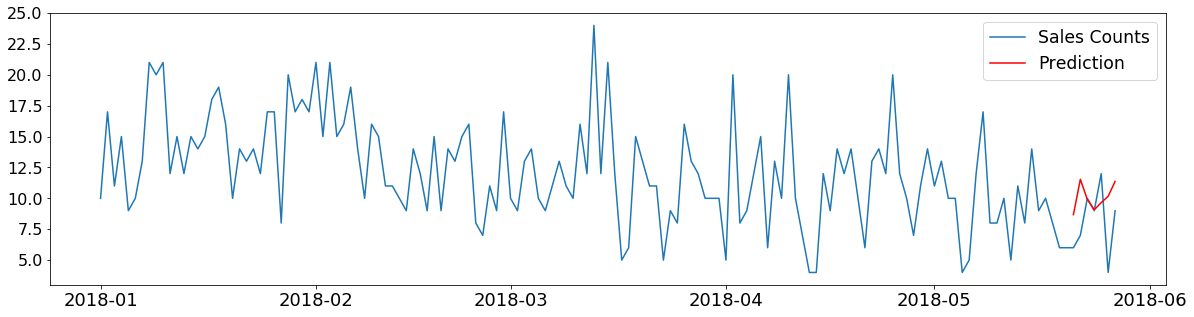

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['count'], label="Sales Counts")
plt.plot(df_test.index, df_test['Prediction'], color='r', label="Prediction")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

## Predicting Beyond the Dataset

* take the whole dataset for training
* scale the data 
* set and train the model
* create prediction
* creat new dates for prediction data

In [16]:
train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 7
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=7)
model.fit_generator(generator, epochs=720, shuffle = False, verbose = 1)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0049
Epoch 2/720
20/20 [==============================] - 0s 21ms/step - loss: 0.0050
Epoch 3/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0046
Epoch 4/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0039
Epoch 5/720
20/20 [==============================] - 0s 19ms/step - loss: 0.0049
Epoch 6/720
20/20 [==============================] - 0s 19ms/step - loss: 0.0047
Epoch 7/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0032
Epoch 8/720
20/20 [==============================] - 1s 27ms/step - loss: 0.0034
Epoch 9/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0033
Epoch 10/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0037
Epoch 11/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 12/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0036
Epoch 13/720
20/20 [=====

20/20 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 102/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 103/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0021
Epoch 104/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0030
Epoch 105/720
20/20 [==============================] - 0s 15ms/step - loss: 0.0022
Epoch 106/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0035
Epoch 107/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 108/720
20/20 [==============================] - 0s 24ms/step - loss: 0.0048
Epoch 109/720
20/20 [==============================] - 0s 14ms/step - loss: 0.0041
Epoch 110/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0036
Epoch 111/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0022
Epoch 112/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0022
Epoch 113/720
20/2

20/20 [==============================] - 0s 20ms/step - loss: 0.0023
Epoch 200/720
20/20 [==============================] - 0s 15ms/step - loss: 0.0028
Epoch 201/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 202/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 203/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0025
Epoch 204/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0024
Epoch 205/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0015
Epoch 206/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0024
Epoch 207/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0031
Epoch 208/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0040
Epoch 209/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0035
Epoch 210/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0028
Epoch 211/720
20/2

20/20 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 298/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 299/720
20/20 [==============================] - 0s 22ms/step - loss: 0.0026
Epoch 300/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 301/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 302/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 303/720
20/20 [==============================] - 0s 15ms/step - loss: 0.0023
Epoch 304/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 305/720
20/20 [==============================] - 0s 21ms/step - loss: 0.0020
Epoch 306/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0023
Epoch 307/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0022
Epoch 308/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0021
Epoch 309/720
20/2

20/20 [==============================] - 0s 16ms/step - loss: 0.0024
Epoch 396/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0017
Epoch 397/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0014
Epoch 398/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0013
Epoch 399/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 400/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0012
Epoch 401/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0014
Epoch 402/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0012
Epoch 403/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0013
Epoch 404/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0021
Epoch 405/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 406/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0014
Epoch 407/720
20/2

20/20 [==============================] - 0s 15ms/step - loss: 0.0018
Epoch 494/720
20/20 [==============================] - 0s 16ms/step - loss: 9.4267e-04
Epoch 495/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 496/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0014
Epoch 497/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0011
Epoch 498/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0010
Epoch 499/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0014
Epoch 500/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0010
Epoch 501/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0013
Epoch 502/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0013
Epoch 503/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0018
Epoch 504/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0015
Epoch 505/720


20/20 [==============================] - 0s 18ms/step - loss: 0.0015
Epoch 592/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0012
Epoch 593/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0017
Epoch 594/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 595/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0015
Epoch 596/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0016
Epoch 597/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 598/720
20/20 [==============================] - 0s 19ms/step - loss: 0.0014
Epoch 599/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 600/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0017
Epoch 601/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0014
Epoch 602/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 603/720
20/2

20/20 [==============================] - 0s 15ms/step - loss: 0.0012
Epoch 689/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0015
Epoch 690/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0015
Epoch 691/720
20/20 [==============================] - 0s 20ms/step - loss: 0.0011
Epoch 692/720
20/20 [==============================] - 0s 18ms/step - loss: 0.0012
Epoch 693/720
20/20 [==============================] - 0s 16ms/step - loss: 0.0012
Epoch 694/720
20/20 [==============================] - 0s 15ms/step - loss: 0.0012
Epoch 695/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0011
Epoch 696/720
20/20 [==============================] - 0s 21ms/step - loss: 0.0016
Epoch 697/720
20/20 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 698/720
20/20 [==============================] - 0s 16ms/step - loss: 8.9555e-04
Epoch 699/720
20/20 [==============================] - 0s 17ms/step - loss: 0.0010
Epoch 700/720


In [17]:
# create new dates for our prediction
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,8) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [18]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

## Prediction Plot

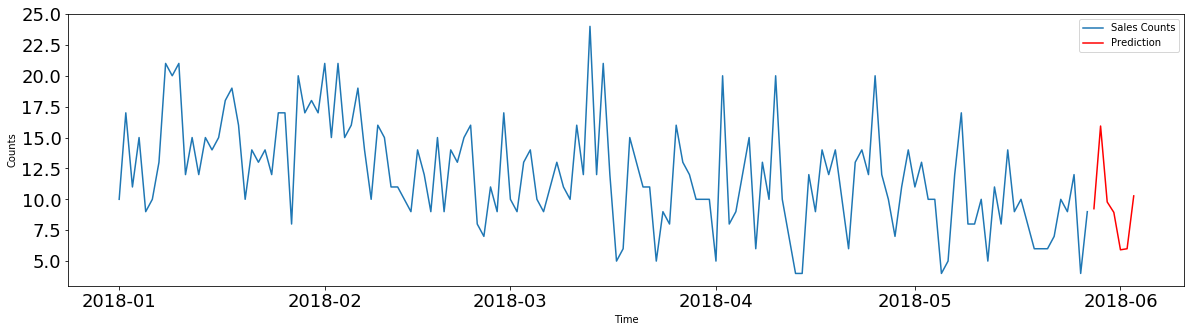

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['count'], label="Sales Counts")
plt.plot(df_proj.index, df_proj['Prediction'], label="Prediction", color='r')
plt.legend(loc='best')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Time")
plt.ylabel("Counts")
plt.show()